In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df=pd.read_csv('feature_selection.csv')

In [4]:
df.shape

(3709, 16)

In [5]:
df.isnull().sum()

price              0
bedRoom            0
bathroom           0
built_up_area      0
study room         0
servant room       0
store room         0
pooja room         0
others             0
furnishing_type    0
floor_type         0
agePossession      0
sector             0
type               0
luxury             0
balcony            0
dtype: int64

In [6]:
df.sample(5)

,price,bedRoom,bathroom,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,floor_type,agePossession,sector,type,luxury,balcony
2156,1.16,5.0,4.0,992.000,0,0,0,0,1,2,3.0,0.0,150.0,1.0,1.0,1.0
2205,9.50,6.0,6.0,4941.000,0,0,0,0,0,0,3.0,0.0,105.0,1.0,1.0,4.0
252,1.15,3.0,4.0,2090.909,0,1,0,0,1,2,3.0,2.0,79.0,0.0,0.0,1.0
669,1.65,3.0,4.0,1267.000,0,1,0,0,0,1,3.0,3.0,151.0,0.0,3.0,3.0
2046,8.50,5.0,6.0,6296.000,1,1,1,1,0,0,1.0,3.0,154.0,1.0,3.0,4.0


# 1. correllation analysis

In [7]:
df.corr()
''' return dataframe (square matrix) having correlation cofficent to each other'''

' return dataframe (square matrix) having correlation cofficent to each other'

In [8]:
df.corr()['price'].sort_values(ascending=False)

price              1.000000
built_up_area      0.691977
bathroom           0.612481
bedRoom            0.550500
type               0.490240
servant room       0.410585
pooja room         0.340448
store room         0.320077
balcony            0.294156
study room         0.252841
floor_type         0.243947
luxury             0.112685
others            -0.013454
agePossession     -0.135878
sector            -0.160586
furnishing_type   -0.244708
Name: price, dtype: float64

Text(0.5, 1.0, 'Heat map')

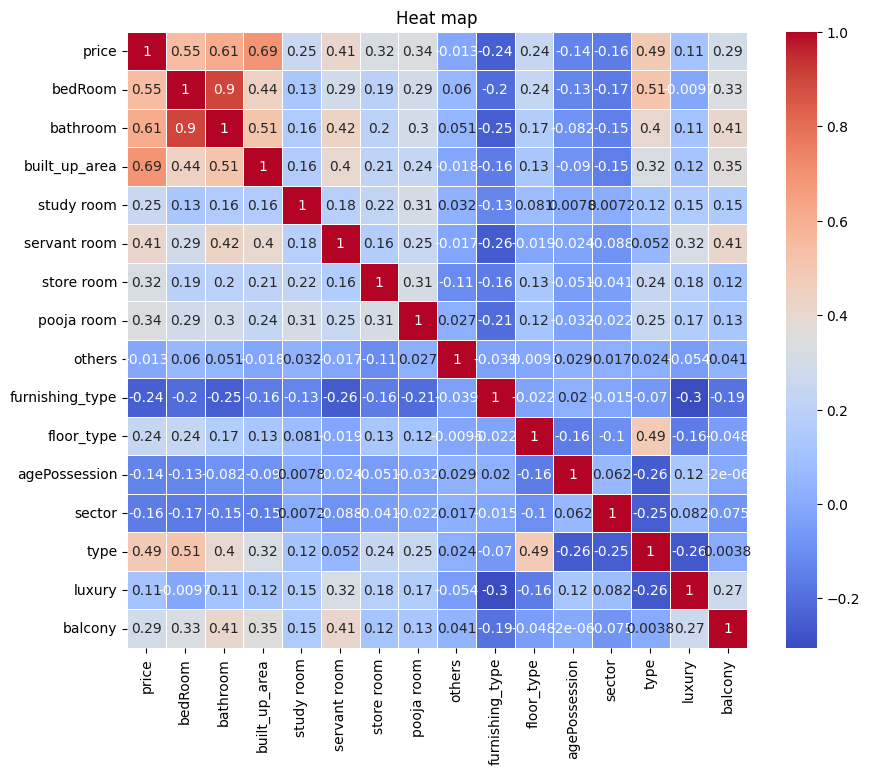

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Heat map')

In [10]:
fi_df1 = df.corr()['price'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','price':'corr_coeff'})
fi_df1.sort_values(by='corr_coeff',ascending=False)

,feature,corr_coeff
2,built_up_area,0.691977
1,bathroom,0.612481
0,bedRoom,0.550500
12,type,0.490240
4,servant room,0.410585
6,pooja room,0.340448
5,store room,0.320077
14,balcony,0.294156
3,study room,0.252841
9,floor_type,0.243947


# 2.Random forest feature importance

In [11]:
from sklearn.ensemble import RandomForestRegressor
x_df=df.iloc[:,1:]
y_df=df.iloc[:,0]
# creating object of randomforest regressor
rf=RandomForestRegressor(n_estimators=100,random_state=42,bootstrap=True,
                         min_impurity_decrease=0.01)
rf.fit(x_df,y_df)
# extracting feature importance
fi_df2=pd.DataFrame(
                 {'feature':x_df.columns,
                'rf_i':rf.feature_importances_}).sort_values(by='rf_i',
                                                                  ascending=False)

In [12]:
fi_df2

,feature,rf_i
2,built_up_area,0.635303
11,sector,0.078991
12,type,0.076943
1,bathroom,0.076114
4,servant room,0.040456
0,bedRoom,0.031409
13,luxury,0.016155
14,balcony,0.008703
10,agePossession,0.007291
9,floor_type,0.006664


# 3.Gradient boosting feature importance

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gr=GradientBoostingRegressor(loss='squared_error',n_estimators=100,min_impurity_decrease=0.01,
                            random_state=42,n_iter_no_change=1)
gr.fit(x_df,y_df)
fi_df3=pd.DataFrame({'feature': x_df.columns,'g_bi':gr.feature_importances_}).sort_values(by='g_bi',ascending=False)
                                                                                                

In [14]:
fi_df3

,feature,g_bi
2,built_up_area,0.631652
11,sector,0.093411
1,bathroom,0.086285
12,type,0.078766
4,servant room,0.051443
0,bedRoom,0.030233
13,luxury,0.010557
6,pooja room,0.007474
9,floor_type,0.004203
5,store room,0.002821


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(gr, x_df, y_df, cv=10, scoring='neg_mean_squared_error')

# Convert the scores to positive (since 'neg_mean_squared_error' is used)
mse_scores = -cross_val_scores

# Print the mean and standard deviation of the cross-validation scores
print("Mean MSE: ", np.mean(mse_scores))
print("Standard Deviation MSE: ", np.std(mse_scores))

Mean MSE:  1.8359333214860427
Standard Deviation MSE:  0.5114760755707448


# 4. Permutation importance

In [16]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(x_df,y_df,test_size=0.3,random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap=True,
                         min_impurity_decrease=0.01)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': x_df.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
2,built_up_area,0.595307
12,type,0.114771
1,bathroom,0.089067
11,sector,0.086245
4,servant room,0.029002
0,bedRoom,0.017146
9,floor_type,0.013376
13,luxury,0.010791
14,balcony,0.002673
6,pooja room,0.002467


# 5. Shap

In [17]:
!pip install shap

In [18]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100,random_state=42,bootstrap=True,
                         min_impurity_decrease=0.01)
rf.fit(x_df,y_df)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_df)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values

array([[-0.0350179 , -0.35743893, -0.80914813, ..., -0.16811159,
         0.02502516,  0.02061695],
       [-0.05088616,  0.44515976, -0.55956802, ..., -0.41615492,
         0.01658395, -0.00128761],
       [-0.03177331, -0.12145447, -0.85371113, ..., -0.13730586,
        -0.02450717,  0.00116544],
       ...,
       [-0.0358694 , -0.10028438, -0.23493822, ..., -0.26233687,
         0.02091299, -0.00136413],
       [-0.05337246,  0.51197511,  0.62888895, ..., -0.43296093,
         0.04841792,  0.00237052],
       [-0.03665329, -0.40812411, -1.06095429, ..., -0.17156581,
         0.01831672,  0.01762169]])

In [19]:
fi_df5 = pd.DataFrame({
    'feature': x_df.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

fi_df5

,feature,SHAP_score
2,built_up_area,1.041847
1,bathroom,0.377823
12,type,0.369832
11,sector,0.236055
4,servant room,0.138174
0,bedRoom,0.062371
13,luxury,0.053641
9,floor_type,0.023324
8,furnishing_type,0.016812
6,pooja room,0.012744


# Combining the results

In [20]:
f_i = (
    fi_df1
    .merge(fi_df2, on='feature')
    .merge(fi_df3, on='feature')
    .merge(fi_df4, on='feature')
    .merge(fi_df5, on='feature')
    .set_index('feature')
)


In [21]:
f_i

,corr_coeff,rf_i,g_bi,permutation_importance,SHAP_score
feature,,,,,
bedRoom,0.550500,0.031409,0.030233,0.017146,0.062371
bathroom,0.612481,0.076114,0.086285,0.089067,0.377823
built_up_area,0.691977,0.635303,0.631652,0.595307,1.041847
study room,0.252841,0.004588,0.000807,-0.004867,0.010816
servant room,0.410585,0.040456,0.051443,0.029002,0.138174
store room,0.320077,0.005230,0.002821,0.001206,0.007661
pooja room,0.340448,0.005095,0.007474,0.002467,0.012744
others,-0.013454,0.000837,0.000000,-0.000611,0.001490
furnishing_type,-0.244708,0.006220,0.001040,0.001105,0.016812


In [22]:
# normalize the dataframe
f_in=f_i.divide(f_i.sum(axis=0),axis=1)

In [23]:
f_in

,corr_coeff,rf_i,g_bi,permutation_importance,SHAP_score
feature,,,,,
bedRoom,0.146203,0.031409,0.030233,0.017877,0.026266
bathroom,0.162664,0.076114,0.086285,0.092862,0.159113
built_up_area,0.183777,0.635303,0.631652,0.620673,0.438755
study room,0.067150,0.004588,0.000807,-0.005074,0.004555
servant room,0.109044,0.040456,0.051443,0.030238,0.058189
store room,0.085007,0.005230,0.002821,0.001257,0.003226
pooja room,0.090417,0.005095,0.007474,0.002572,0.005367
others,-0.003573,0.000837,0.000000,-0.000637,0.000628
furnishing_type,-0.064990,0.006220,0.001040,0.001152,0.007080


In [24]:
f_in[['rf_i','g_bi','permutation_importance','SHAP_score']].mean(axis=1).sort_values(ascending=False)

feature
built_up_area      0.581596
type               0.107780
bathroom           0.103593
sector             0.090433
servant room       0.045081
bedRoom            0.026446
luxury             0.015138
floor_type         0.008659
pooja room         0.005127
balcony            0.004169
furnishing_type    0.003873
agePossession      0.003545
store room         0.003134
study room         0.001219
others             0.000207
dtype: float64

In [25]:
# drop columns--> others,store room,study room
m_f=x_df.drop(columns=['others','store room','study room'],axis=1)

In [26]:
m_f.head()

,bedRoom,bathroom,built_up_area,servant room,pooja room,furnishing_type,floor_type,agePossession,sector,type,luxury,balcony
0,2.0,1.0,1069.0,0,0,2,3.0,2.0,98.0,0.0,2.0,0.0
1,3.0,5.0,1597.6,1,0,0,2.0,3.0,181.0,0.0,1.0,3.0
2,3.0,3.0,965.0,0,0,2,3.0,1.0,110.0,0.0,0.0,3.0
3,3.0,4.0,1680.0,1,0,1,1.0,3.0,164.0,0.0,2.0,4.0
4,3.0,4.0,1682.4,1,0,1,2.0,3.0,164.0,0.0,3.0,4.0


In [ ]:
m_f.to